<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Tver_elastisity_update_v2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
# import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [3]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [32]:
from git import Repo
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElasticity

Cloning into 'NewElasticity'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 220 (delta 80), reused 4 (delta 4), pack-reused 100
Receiving objects: 100% (220/220), 6.15 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (152/152), done.


# Preparation part

In [33]:
# Colab
path_to_ser = Path('/content/NewElasticity/Tver.xlsx')
# PS
# path_to_ser = Path('/Users/maryiakalinina/Desktop/Tver.xlsx')

df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [35]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [36]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (air),Mineralogical density,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 16,AR thermal,AO electrical,Unnamed: 19,Unnamed: 20,TC avg,TCav,TCav.1,TCav.2,TCav.3,TCav.4,"Porosity,%.1",Permeability_calc,Permeability_fluid,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Kozeney-Carman,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.562685,2.684139,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,NaN,2.472888,2.668885,NaN,2.740225,2.966438,2.852613,4.524900,0.870000,203.091762,4.474260,NaN,c,2.00,0.470106,1.032229,NaN,NaN,0.01
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.532158,2.709034,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,NaN,2.404575,2.600888,2.745500,2.741125,2.857375,2.834588,6.473371,0.294473,49.238826,16.069972,NaN,s,14.25,0.393038,4.323768,NaN,NaN,10000.00
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.295220,2.708188,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,NaN,1.858550,2.234582,2.535225,2.514712,2.630950,2.677875,15.024288,19.332058,412.462638,5.440304,NaN,t,NaN,0.257990,125.463065,NaN,NaN,NaN
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.324111,2.712252,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,NaN,1.867175,2.286873,2.619337,2.604425,2.728613,2.715700,14.192654,18.098140,412.462638,4.348734,NaN,NaN,NaN,0.265441,99.906718,NaN,NaN,NaN
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.448883,2.706714,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,2.123563,2.400862,2.661125,2.623087,2.823100,2.718675,9.432966,15.311311,587.801607,-2.951696,NaN,NaN,NaN,0.325594,19.495454,NaN,NaN,NaN


In [37]:
data[['Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil', 'Vs oil']].describe()

,Vp air,Vs air,Vp water,Vs water,Vp oil,Vs oil
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.049354,2.347747,4.734121,2.500788,4.801224,2.647978
std,0.785375,0.394807,0.634691,0.349465,0.684056,0.374006
min,2.212333,1.323000,3.259500,1.718500,3.167705,1.825235
25%,3.514333,2.076667,4.405000,2.233000,4.224880,2.373170
50%,4.042333,2.360000,4.900000,2.582000,4.972040,2.704390
75%,4.839333,2.675000,5.211500,2.723500,5.190400,2.876360
max,5.199333,2.883000,5.674000,2.991500,5.958540,3.269995


In [38]:
data['Vp/Vs air'] = data[['Vp air', 'Vs air']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs water'] = data[['Vp water', 'Vs water']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs oil'] = data[['Vp oil', 'Vs oil']].apply(lambda x: x[0]/x[1], axis=1)

data['Vp Water/Oil Diff'] = data[['Vp water', 'Vp oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)
data['Vs Water/Oil Diff'] = data[['Vs water', 'Vs oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)

In [39]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [40]:
    ### Moduli Air
data['K air'] = data[['Vp air', 'Vs air', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu air'] = data[['Vs air', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Water
data['K water'] = data[['Vp water', 'Vs water', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu water'] = data[['Vs water', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Oil
data['K oil'] = data[['Vp oil', 'Vs oil', 'Density (oil)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu oil'] = data[['Vs oil', 'Density (oil)']].apply(lambda x: x[1] * x[0]**2, axis=1)

In [41]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (air),Mineralogical density,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 16,AR thermal,AO electrical,Unnamed: 19,Unnamed: 20,TC avg,TCav,TCav.1,TCav.2,TCav.3,TCav.4,"Porosity,%.1",Permeability_calc,Permeability_fluid,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Kozeney-Carman,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Vp/Vs air,Vp/Vs water,Vp/Vs oil,Vp Water/Oil Diff,Vs Water/Oil Diff,K air,Mu air,K water,Mu water,K oil,Mu oil
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.562685,2.684139,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,NaN,2.472888,2.668885,NaN,2.740225,2.966438,2.852613,4.524900,0.870000,203.091762,4.474260,NaN,c,2.00,0.470106,1.032229,NaN,NaN,0.01,2.134322,1.998302,1.842867,-4.85,-12.25,46.159570,14.326384,48.028807,18.056785,48.450587,23.487506
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.532158,2.709034,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,NaN,2.404575,2.600888,2.745500,2.741125,2.857375,2.834588,6.473371,0.294473,49.238826,16.069972,NaN,s,14.25,0.393038,4.323768,NaN,NaN,10000.00,1.665111,1.896623,1.815870,-2.30,-6.46,21.521152,14.952932,40.793349,18.019497,40.324913,20.531503
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.295220,2.708188,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,NaN,1.858550,2.234582,2.535225,2.514712,2.630950,2.677875,15.024288,19.332058,412.462638,5.440304,NaN,t,NaN,0.257990,125.463065,NaN,NaN,NaN,1.759806,1.804075,1.818652,-1.82,-1.03,16.072570,9.113578,21.893623,11.394892,23.087306,11.694747
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.324111,2.712252,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,NaN,1.867175,2.286873,2.619337,2.604425,2.728613,2.715700,14.192654,18.098140,412.462638,4.348734,NaN,NaN,NaN,0.265441,99.906718,NaN,NaN,NaN,1.763650,1.880947,1.834958,-3.92,-6.27,13.959632,7.855171,21.101203,9.571328,22.092591,10.863045
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.448883,2.706714,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,2.123563,2.400862,2.661125,2.623087,2.823100,2.718675,9.432966,15.311311,587.801607,-2.951696,NaN,NaN,NaN,0.325594,19.495454,NaN,NaN,NaN,1.625910,1.928486,1.855972,1.41,-2.40,17.592209,13.426620,36.765377,15.410573,33.965842,16.087646


In [42]:
data[['Vp Water/Oil Diff', 'Vs Water/Oil Diff']].describe()

,Vp Water/Oil Diff,Vs Water/Oil Diff
count,33.000000,33.000000
mean,-1.018788,-5.234242
std,7.620490,8.221110
min,-21.120000,-24.470000
25%,-4.850000,-10.100000
50%,-1.770000,-6.180000
75%,1.840000,-2.400000
max,31.430000,25.300000


Text(0, 0.5, 'Absolute Percentage Error, %')

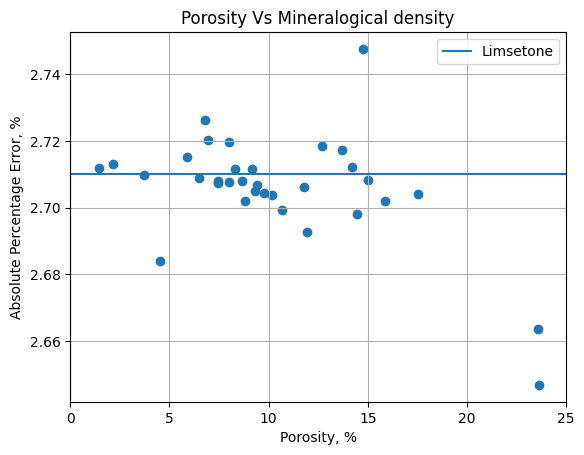

In [43]:
plt.scatter(data['Porosity,%'], data['Mineralogical density'], marker='o')
plt.plot([0, 25], [2.71, 2.71], label='Limsetone')
plt.title('Porosity Vs Mineralogical density')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

Text(0, 0.5, 'Absolute Percentage Error, %')

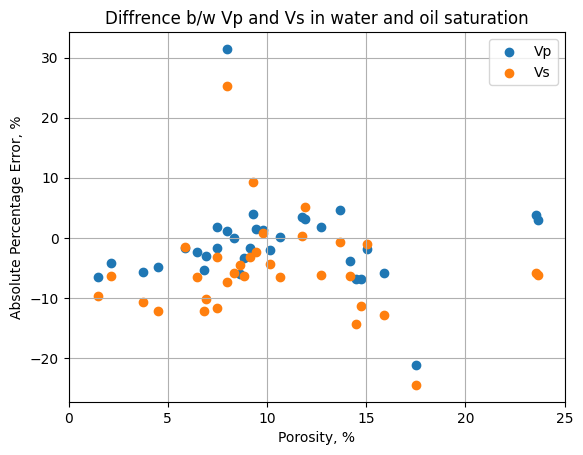

In [44]:
plt.scatter(data['Porosity,%'], data['Vp Water/Oil Diff'], label='Vp')
plt.scatter(data['Porosity,%'], data['Vs Water/Oil Diff'], label='Vs')
plt.title('Diffrence b/w Vp and Vs in water and oil saturation')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

Plot of acoustic and shear impedance.
$Z_{acoustic} = V_{p}*\rho$, $Z_{shear} = V_{s}*\rho$

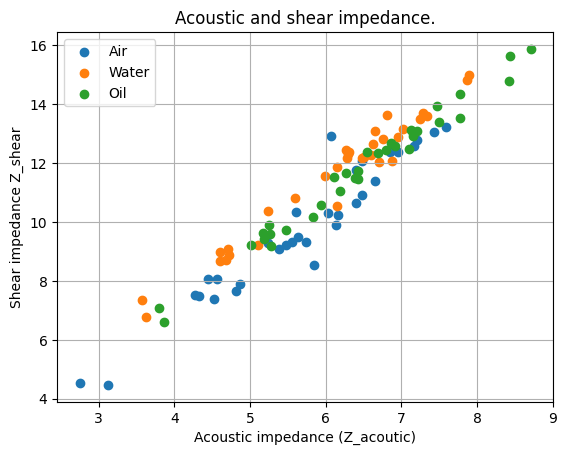

In [46]:
plt.scatter(data['Vs air']*data['Density (water)'], data['Vp air']*data['Density (air)'], label='Air')
plt.scatter(data['Vs water']*data['Density (water)'], data['Vp water']*data['Density (water)'], label='Water')
plt.scatter(data['Vs oil']*data['Density (oil)'], data['Vp oil']*data['Density (oil)'], label='Oil')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.title('Acoustic and shear impedance.')
plt.xlabel('Acoustic impedance (Z_acoutic)')
plt.ylabel('Shear impedance Z_shear')
plt.legend()
plt.grid()

Plot of vertical P-wave velocity versus vertical S-wave velocity to distinguish different lithologies.

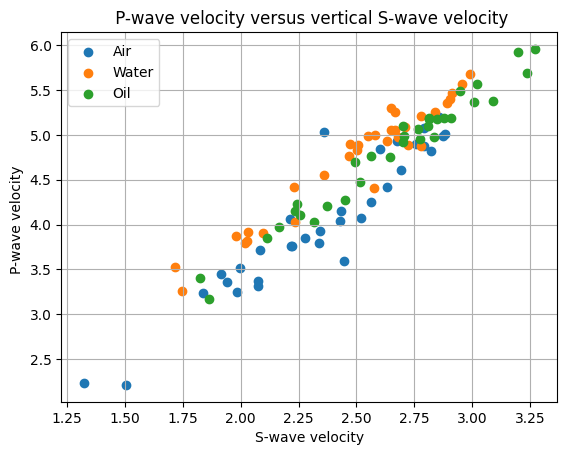

In [47]:
plt.scatter(data['Vs air'], data['Vp air'], label='Air')
plt.scatter(data['Vs water'], data['Vp water'], label='Water')
plt.scatter(data['Vs oil'], data['Vp oil'], label='Oil')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.title(' P-wave velocity versus vertical S-wave velocity')
plt.xlabel('S-wave velocity')
plt.ylabel('P-wave velocity ')
plt.legend()
plt.grid()

$Susan, 1992$
https://www.crewes.org/Documents/ResearchReports/1992/1992-12.pdf

https://www.researchgate.net/publication/249866305_Changes_in_dynamic_shear_moduli_of_carbonate_rocks_with_fluid_substitution

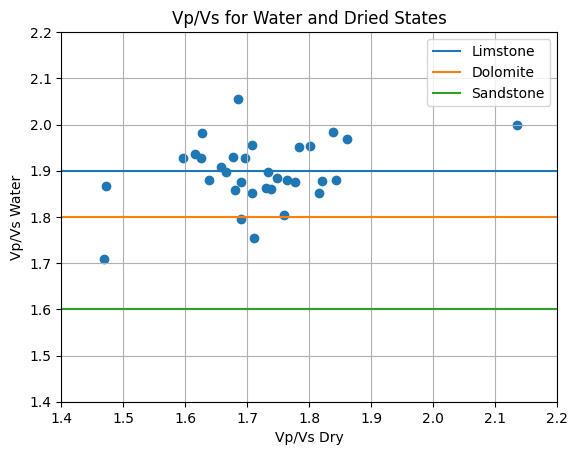

In [48]:
plt.scatter(data['Vp/Vs air'], data['Vp/Vs water'])
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
plt.xlim(1.4, 2.2)
plt.ylim(1.4, 2.2)
plt.title('Vp/Vs for Water and Dried States')
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

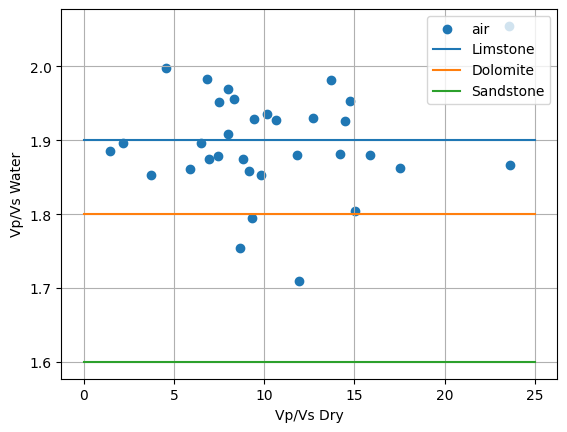

In [49]:
# plt.scatter(data['Porosity,%'], data['Vp/Vs air'], label='air')
plt.scatter(data['Porosity,%'], data['Vp/Vs water'], label='air')
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

### Vp, Vs, density of minerals
- Calcite Peselnick and Robie (1963) Vp=6.54 Vs=3.35, p=2.71
- Dolomite Ahrens (1995) Vp=6.40; Vs=3.46 p=2.86

In [50]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [51]:
### Calcite. (Известняк состоит преимущественно из кальцита)
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])
p_calcite = 2.71
### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [52]:
K_calcite, mu_calcite

(75.36040266666667, 30.412975)

In [53]:
K_dolomite, mu_dolomite

(71.49389866666668, 34.238776)

In [54]:

K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

### Voight and Hashin-Strikman boundes

In [55]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [56]:
K_matrix, Mu_matrix = K_calcite, mu_calcite

In [57]:
K_fluid, Mu_fluid = K_air, Mu_air

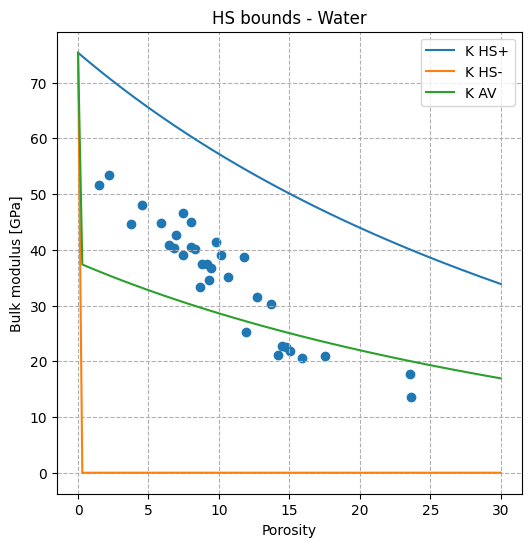

In [58]:
porosity = np.linspace(0, 0.3, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)



plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('HS bounds - Water')

plt.plot(porosity*100, K_up_value,label='K HS+')
plt.plot(porosity*100, K_lo_value,label='K HS-')
plt.plot(porosity*100, K_av_value,label='K AV')

plt.scatter(data['Porosity,%'], data['K water'])

plt.legend(loc='best')
plt.grid(ls='--')

### Расчет модулей матрицы для разных состояний насыщения по уравнению регрессии "пористость - скорость"

In [59]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    density = 2.71
    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

значения скоростей из уравнения регрессии "пористость - скорость"

In [60]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


HS bourders for K and Mu moduli in diffrent saturation states.
--> All samples are inside bourdes for which Calcite moduli K and mu were used.

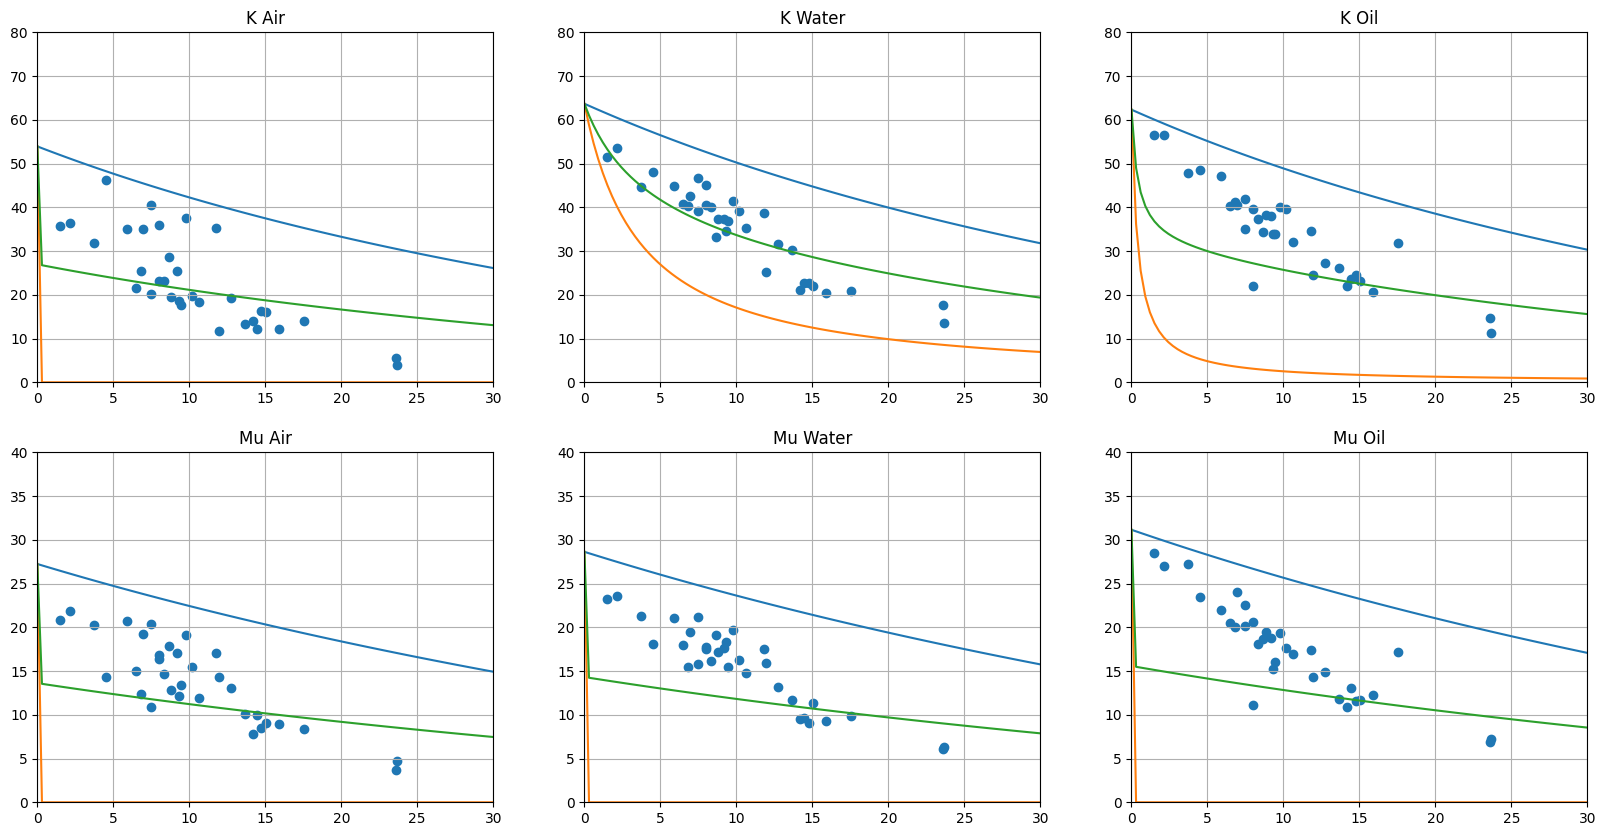

In [61]:
fig = plt.figure(figsize=(20, 10))

porosity = np.linspace(0, 0.3, 100, endpoint=True)

    ### Вариант 1: модули матрицы (кальцит) одинаковый для
    ### состояний насыщения
# K_matrix, Mu_matrix = K_calcite, mu_calcite
# MODULI = {
#     "K Air": [data['K air'], K_matrix, K_air, Mu_matrix, Mu_air],
#     "K Water":[data['K water'], K_matrix, K_water, Mu_matrix, Mu_water],
#     "K Oil" : [data['K oil'],K_matrix, K_oil, Mu_matrix, Mu_oil],
#     "Mu Air" : [data['Mu air'], K_matrix, K_air, Mu_matrix, Mu_air],
#      "Mu Water" : [data['Mu water'], K_matrix, K_water, Mu_matrix, Mu_water],
#      "Mu Oil" : [data['Mu oil'], K_matrix, K_oil, Mu_matrix, Mu_oil]
# }

    ### Вариант 2: модули матрицы разные (из уравнения регресии пористость - скорость)
    ### для трех состояний насыщения
MODULI = {
    "K Air": [data['K air'], K_air_mtrx, K_air, Mu_air_mtrx, Mu_air],
    "K Water":[data['K water'], K_water_mtrx, K_water, Mu_water_mtrx, Mu_water],
    "K Oil" : [data['K oil'],K_oil_mtrx, K_oil, Mu_oil_mtrx, Mu_oil],

    "Mu Air" : [data['Mu air'], K_air_mtrx, K_air, Mu_air_mtrx, Mu_air],
     "Mu Water" : [data['Mu water'], K_water_mtrx, K_water, Mu_water_mtrx, Mu_water],
     "Mu Oil" : [data['Mu oil'], K_oil_mtrx, K_oil, Mu_oil_mtrx, Mu_oil]
}

for index, (name, moduli) in enumerate(MODULI.items()):

  K_matrix, K_fluid, Mu_matrix, Mu_fluid = moduli[1], moduli[2], moduli[3], moduli[4]

  K_up_value, K_lo_value, K_av_value = [], [], []
  Mu_up_value, Mu_lo_value, Mu_av_value = [], [], []

  for phi in porosity:
    K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
    K_up, K_lo, K_av, Mu_up, Mu_lo, Mu_av  = HS_borders(K, μ, f)

    K_up_value.append(K_up)
    K_lo_value.append(K_lo)
    K_av_value.append(K_av)

    Mu_up_value.append(Mu_up)
    Mu_lo_value.append(Mu_lo)
    Mu_av_value.append(Mu_av)


  ax = plt.subplot(2, 3, index + 1)
  plt.scatter(data['Porosity,%'], moduli[0])

  if index < 3: ### K moduli (upper plots)
    plt.plot(porosity*100, K_up_value,label='K HS+')
    plt.plot(porosity*100, K_lo_value,label='K HS-')
    plt.plot(porosity*100, K_av_value,label='K AV')
    plt.ylim(0, 80)

  else: ### Mu moduli (bottom plots)
    plt.plot(porosity*100, Mu_up_value,label='K HS+')
    plt.plot(porosity*100, Mu_lo_value,label='K HS-')
    plt.plot(porosity*100, Mu_av_value,label='K AV')
    plt.ylim(0, 40)

  plt.grid()
  plt.xlim(0, 30)
  plt.title(f'{name}')

# GSA isotropic

In [62]:
import numpy as np
# import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

### Voight natation - matrix to tensor and vice virce

In [63]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.empty((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

### Input data

In [64]:
# M_C11 = K_matrix + 4/3*Mu_matrix
# M_C44 = Mu_matrix
# M_C12 = M_C11 - 2*M_C44


# C_mtrx = np.zeros((6,6))
# C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
# C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
# C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

# C_mtrx = mat2tens(C_mtrx, compl=False)
# C_c = C_mtrx


# k, mu = K_fluid, Mu_fluid

# lambda_ = k - 2 * mu / 3
# c11 = lambda_ + 2 * mu
# c12 = lambda_
# c44 = mu

# Fl_C11 = c11
# Fl_C12 = c12
# Fl_C44 = (Fl_C11 - Fl_C12)*0.5

# C_fl = np.zeros((6, 6))
# C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
# C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
# C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

# C_fl = mat2tens(C_fl, compl=False)

In [65]:
def make_C_matrix(K_matrix, Mu_matrix):

  M_C11 = K_matrix + 4/3*Mu_matrix
  M_C44 = Mu_matrix
  M_C12 = M_C11 - 2*M_C44


  C_mtrx = np.zeros((6,6))
  C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
  C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
  C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

  C_mtrx = mat2tens(C_mtrx, compl=False)

  return C_mtrx

In [66]:
def make_C_fluid (K_fluid, Mu_fluid):

  k, mu = K_fluid, Mu_fluid

  lambda_ = k - 2 * mu / 3
  c11 = lambda_ + 2 * mu
  c12 = lambda_
  c44 = mu

  Fl_C11 = c11
  Fl_C12 = c12
  Fl_C44 = (Fl_C11 - Fl_C12)*0.5

  C_fl = np.zeros((6, 6))
  C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
  C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
  C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

  C_fl = mat2tens(C_fl, compl=False)

  return C_fl

In [67]:
def make_C_comparison(C_mtrx, C_fluid, f):
  return (1-f)*C_mtrx + f*C_fluid

### Tensor $g_{ijkl}$ calculation

In [68]:
pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-6
    relerr = 1.0e-6
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

                  if abs(integrals[i, j, k, l]) > 10**-10:
                    pass
                  else:
                    integrals[i, j, k, l] = 10**-20

    # print(tens2mat(integrals, compl=True))

    return integrals

In [69]:
def tensor_g_fast(C_c, AR):
    pi = np.pi

    def func(θ, φ, position):
      n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                      (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                      (np.cos(θ)*AR[2]**-1)]])



      n = n_vector.T @ n_vector

      n = n.astype(np.float64)

      λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
      return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                          position[1],
                                                          position[2],
                                                          position[3]]  # Return a scalar value

    integrals = np.zeros((3, 3, 3, 3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    opts = {'epsabs': abserr, 'epsrel': relerr}

    valid_combinations = {(0, 0, 0, 0), (0, 0, 1, 1), (1, 1, 0, 0), (0, 2, 0, 2), (1, 1, 1, 1), (2, 2, 2, 2),
                          (0, 0, 2, 2), (1, 1, 2, 2), (2, 2, 0, 0), (2, 2, 1, 1), (0, 2, 2, 0), (2, 0, 2, 0),
                          (2, 0, 0, 2), (0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 2, 1, 2),
                          (1, 2, 2, 1), (2, 1, 1, 2), (2, 1, 2, 1)}

    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):
                    if (i, j, k, l) in valid_combinations:
                        integrand = lambda θ, φ, i=i, j=j, k=k, l=l: (
                            func(θ, φ, (i, k, l, j)) + func(θ, φ, (j, k, l, i)) +
                            func(θ, φ, (i, l, k, j)) + func(θ, φ, (j, l, k, i))) * np.sin(θ)

                        integral, _ = integrate.nquad(integrand, [(0, pi), (0, 2 * pi)], opts=opts)
                        integrals[i, j, k, l] = integral / (-16 * pi)
                    else:
                        integrals[i, j, k, l] = 10 ** -20

    # print(tens2mat(integrals, compl=True))

    return integrals

### Transition from laboratory system (xyz) of VTI symmetry to XYZ system with isotopy

In [70]:
def izotr(c):

  pi = np.pi
  c_iz = np.zeros((3, 3, 3, 3))

  c11 = c[0, 0, 0, 0]
  c22 = c[1, 1, 1, 1]
  c33 = c[2, 2, 2, 2]
  c12 = c[0, 0, 1, 1]
  c13 = c[0, 0, 2, 2]
  c23 = c[1, 1, 2, 2]
  c44 = c[1, 2, 1, 2]
  c55 = c[0, 2, 0, 2]
  c66 = c[0, 1, 0, 1]

  t1 = 0.3141593E1**2
  t20 = 32.E0/15.E0*c44*t1 + 8.E0/5.E0*c22*t1 + 16.E0/15.E0*c23*t1 + 32.E0/15.E0*c55*t1 + 8.E0/5.E0*c11*t1 + 32.E0/15.E0*c66*t1 + 16.E0/15.E0*c13*t1 + 16.E0/15.E0*c12*t1 + 8.E0/5.E0*c33*t1
  c_iz[0, 0, 0, 0] = t20 / (8 * pi * pi)

  t20 = 32.E0/15.E0*c12*t1 + 8.E0/15.E0*c11*t1 + 8.E0/15.E0*c22*t1 - 16.E0/15.E0*c66*t1 + 32.E0/15.E0*c13*t1 + 32.E0/15.E0*c23*t1 - 16.E0/15.E0*c44*t1 + 8.E0/15.E0*c33*t1 - 16.E0/15.E0*c55*t1
  c_iz[0, 0, 1, 1] = t20 / (8 * pi * pi)
  c_iz[1, 1, 0, 0] = c_iz[0, 0, 1, 1]

  t20 = -8.E0/15.E0*c12*t1 + 8.E0/15.E0*c22*t1 + 8.E0/5.E0*c44*t1 + 8.E0/5.E0*c55*t1 + 8.E0/15.E0*c11*t1 + 8.E0/5.E0*c66*t1 - 8.E0/15.E0*c13*t1 - 8.E0/15.E0*c23*t1 + 8.E0/15.E0*c33*t1
  c_iz[0, 2, 0, 2] = t20 / (8 * pi * pi)

  c_iz[1, 1, 1, 1] = c_iz[0, 0, 0, 0]
  c_iz[2, 2, 2, 2] = c_iz[0, 0, 0, 0]
  c_iz[0, 0, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[1, 1, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 0, 0] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 1, 1] = c_iz[0, 0, 1, 1]
  c_iz[0, 2, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 0, 2] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 2, 1] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 2, 1] = c_iz[0, 2, 0, 2]

  return c_iz

### $C_{eff}$ calculation

In [71]:
def effective_C_isotropic(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  num_fl_rotated = izotr(mat2tens(num_fl, compl=False))
  ### -----------


  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*tens2mat(num_fl_rotated, compl=False))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity) # matrix shape
  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ result_fl, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b) # tensor shape

  aa = mat2tens(np.linalg.inv(g_matrix), compl=False)
  bb = tens2mat(np.einsum('ijmn,nmkl->ijkl', aa, B), compl=False)

  result_fl_rotated = g_matrix @ bb

  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl_rotated)


        ### Effective matrix Cij in laboratory system
  C_eff = rslt_num @ rslt_dnmntr

  return C_eff

# Inversion problem for three fluids in material inclusion

In [ ]:
### Measured parametrs
idx = 3 #порядкой номер образцы в исходной таблице
porosity_measured = data['Porosity,%'][idx]
Vp_air_measured = data['Vp air'][idx]
Vs_air_measured = data['Vs air'][idx]

Определение плотности породы в высушенном состоянии с использованием измеренных данных о плотности породы в водонасыщенном.

In [72]:
def density_rock_air(ro_1, ro_matrix, ro_water, ro_air, phi):
    pm = (ro_1 - phi*ro_water)/(1-phi)
    ro2 = (1-phi)*pm + phi*ro_air
    return ro2

# Given values
ro_1 = 2.326067	 #измерения плотности породы по воде
ro_matrix = 2.69 # значение из уравнения регрессии (плотность по воде - пористость )
ro_water = p_water
ro_air = p_air
phi = porosity_measured /100

ro2_solution = density_rock_air(ro_1, ro_matrix, ro_water, ro_air, phi)
print("The solution for ro2 is:", np.round(ro2_solution, 2))

NameError: name 'porosity_measured' is not defined

In [ ]:
porosity_measured

14.192653640237129

In [ ]:
# def self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity):

#   g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#   g_inclusion= tensor_g_fast(C_c, [10, 10, 1])

#   x0 = C_c
#   C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)
#   it = 1
#   print(it)
#   print('Comparison body', np.round(tens2mat(x0, compl=False), 2))
#   print('Effective_value', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')


#   while not np.all(np.round(x0, 2) == np.round(C_c, 2)):

#     x0 = C_c
#     g_matrix = tensor_g_fast(x0, [1, 1, 1])
#     g_inclusion= tensor_g_fast(x0, [10, 10, 1])

#     C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

#     it +=1
#     print('Iteration:', it)
#     print('Comparison body', np.round(tens2mat(x0, compl=False), 2))
#     print('Effective_value', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

#   else:
#     print('Final')
#     return np.round(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), 2)



In [77]:
### Function to use self-consistent method of GSA. Applied. if comparison body is equal to
### mineral matrix. Works iterativly

def self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion):
#     it = 1
    g_matrix = tensor_g_fast(C_c, [1, 1, 1])
    g_inclusion = tensor_g_fast(C_c, AR_inclusion)

    x0 = C_c
    C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

    # print(f"Iteration: {it}")
    # print('Comparison body:', np.round(tens2mat(x0, compl=False), 2))
    # print('Effective_value:', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

    while not np.all(np.round(x0, 2) == np.round(C_c, 2)):
        x0 = C_c
        g_matrix = tensor_g_fast(x0, [1, 1, 1])
        g_inclusion = tensor_g_fast(x0, AR_inclusion)

        C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

#         it += 1
#         print(f"Iteration: {it}")
    #     print('Comparison body:', np.round(tens2mat(x0, compl=False), 2))
    #     print('Effective_value:', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

    # print('Final')
    return effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity) #return - C_eff in matrix form

In [ ]:
np.logspace(-1.3, -1, num=6)

array([0.05011872, 0.05754399, 0.06606934, 0.07585776, 0.08709636,
       0.1       ])

Выбор метода: самосогласования или f-модель

In [ ]:
c11_air, c12_air, c44_air = [], [], []
c11_water, c12_water, c44_water = [], [], []
c11_oil, c12_oil, c44_oil = [], [], []

# porosity = data['Porosity,%'][idx]/100
porosity = 14.47/100
print(porosity)


AR = np.logspace(1.3, 1, num=6)
print(AR)
AR_loop = AR**-1 #для построения графиков
print(AR_loop, end='\n\n')

# C_mtrx = make_C_matrix(K_calcite, mu_calcite)
# C_c = C_mtrx
# g_matrix = tensor_g_fast(C_c, [1, 1, 1])

f = 0

for i in AR:
    print(i, 1/i)

### Air
    C_mtrx = make_C_matrix(K_air_mtrx, Mu_air_mtrx)
    C_fluid = make_C_fluid(K_air, Mu_air)

    AR_inclusion = [i,i,1]

    if f != 0: #f-model
        print('f-model')
        C_c = C_mtrx*(1-f) + C_fluid*f

        g_matrix = tensor_g_fast(C_c, [1, 1, 1])
        g_inclusion= tensor_g_fast(C_c, AR_inclusion)
        eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                      C_fluid, C_c, porosity)
        c11_air.append(eff_air[0,0])
        c12_air.append(eff_air[0,2])
        c44_air.append(eff_air[3,3])

    else: #self-consistent
        print('self-consistent')
        C_c = C_mtrx
        eff_air = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)

        c11_air.append(eff_air[0,0])
        c12_air.append(eff_air[0,2])
        c44_air.append(eff_air[3,3])
        print('air')
        print(eff_air[0,0], eff_air[0,2], eff_air[3,3])


### Water

    C_mtrx = make_C_matrix(K_water_mtrx, Mu_water_mtrx)
    C_fluid = make_C_fluid(K_water, Mu_water)

    AR_inclusion = [i,i,1]

    if f != 0: #f-model
        print('f-model')
        C_c = C_mtrx*(1-f) + C_fluid*f

        g_matrix = tensor_g_fast(C_c, [1, 1, 1])
        g_inclusion= tensor_g_fast(C_c, AR_inclusion)
        eff_water = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                      C_fluid, C_c, porosity)
        c11_water.append(eff_water[0,0])
        c12_water.append(eff_water[0,2])
        c44_water.append(eff_water[3,3])

    else: #self-consistent
        print('self-consistent')
        C_c = C_mtrx
        eff_water = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)

        c11_water.append(eff_water[0,0])
        c12_water.append(eff_water[0,2])
        c44_water.append(eff_water[3,3])
        print('water')
        print(eff_water[0,0], eff_water[0,2], eff_water[3,3])

#     C_mtrx = make_C_matrix(K_water_mtrx, Mu_water_mtrx)
#     C_fluid = make_C_fluid(K_oil, Mu_oil)
#     C_c = C_mtrx*(1-f) + C_fluid*f

#     g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#     g_inclusion= tensor_g_fast(C_c, [i, i, 1])
#     eff_water = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
#                                  C_fluid, C_c, porosity)
#     c11_water.append(eff_water[0,0])
#     c12_water.append(eff_water[0,2])
#     c44_water.append(eff_water[3,3])

# ### Oil
#   C_mtrx = make_C_matrix(K_oil_mtrx, Mu_oil_mtrx)
#   C_fluid = make_C_fluid(K_oil, Mu_oil)
#   C_c = C_mtrx*(1-f) + C_fluid*f

#   g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#   g_inclusion= tensor_g_fast(C_c, [i, i, 1])
#   eff_oil = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
#                                  C_fluid, C_c, porosity)
#   c11_oil.append(eff_oil[0,0])
#   c12_oil.append(eff_oil[0,2])
#   c44_oil.append(eff_oil[3,3])

0.1447
[19.95262315 17.37800829 15.13561248 13.18256739 11.48153621 10.        ]
[0.05011872 0.05754399 0.06606934 0.07585776 0.08709636 0.1       ]

19.952623149688797 0.05011872336272723
self-consistent
air
9.547770799050438 2.686949948923573 3.4304104250634317
self-consistent
water
39.92777463829414 22.691408195752743 8.618183221270698
17.378008287493753 0.0575439937337157
self-consistent
air
14.458459449976138 4.350718884595492 5.053870282690324
self-consistent
water
41.971996058111 22.854969669373485 9.558513194368768
15.13561248436208 0.06606934480075961
self-consistent
air
19.35634305895613 6.159286917192439 6.598528070881843
self-consistent
water
44.126502813703205 23.146145445995828 10.490178683853685
13.182567385564074 0.07585775750291836
self-consistent
air
24.149100746883843 8.047108076026978 8.050996335428431
self-consistent
water
46.36881945724469 23.56168120292665 11.403569127159018
11.481536214968829 0.08709635899560805
self-consistent
air
28.7913521392574 9.96521779610

In [82]:
AR = np.logspace(0.4, 0.1, num=6)
print(1/AR)

[0.39810717 0.45708819 0.52480746 0.60255959 0.69183097 0.79432823]


### Обратная задача с вариацией матрицы

In [83]:
c11_air, c12_air, c44_air = [], [], []
c11_water, c12_water, c44_water = [], [], []
c11_oil, c12_oil, c44_oil = [], [], []

# porosity = data['Porosity,%'][idx]/100
porosity = 15.02/100
print(porosity)


# AR = np.logspace(1.3, 0.8, num=6)
AR = np.logspace(0.4, 0.8, num=6)
print(AR)
AR_loop = AR**-1 #для построения графиков
print(AR_loop, end='\n\n')

# C_mtrx = make_C_matrix(K_calcite, mu_calcite)
# C_c = C_mtrx
# g_matrix = tensor_g_fast(C_c, [1, 1, 1])

error = 0.05
K_air_matix_range = [K_air_mtrx-K_air_mtrx*error, K_air_mtrx, K_air_mtrx+K_air_mtrx*0.05]
Mu_air_matix_range = [Mu_air_mtrx-Mu_air_mtrx*error, Mu_air_mtrx, Mu_air_mtrx+Mu_air_mtrx*0.05]


f = 0

for i in AR:
    print(i, 1/i)

    for k, mu in zip(K_air_matix_range, Mu_air_matix_range):
      print(k, mu)
### Air
      C_mtrx = make_C_matrix(k, mu)
      C_fluid = make_C_fluid(K_air, Mu_air)

      AR_inclusion = [i,i,1]

      if f != 0: #f-model
          print('f-model')
          C_c = C_mtrx*(1-f) + C_fluid*f

          g_matrix = tensor_g_fast(C_c, [1, 1, 1])
          g_inclusion= tensor_g_fast(C_c, AR_inclusion)
          eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                        C_fluid, C_c, porosity)
          c11_air.append(eff_air[0,0])
          c12_air.append(eff_air[0,2])
          c44_air.append(eff_air[3,3])

      else: #self-consistent
          print('self-consistent')
          C_c = C_mtrx
          eff_air = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)

          c11_air.append(eff_air[0,0])
          c12_air.append(eff_air[0,2])
          c44_air.append(eff_air[3,3])
          print('air')
          print(eff_air[0,0], eff_air[0,2], eff_air[3,3])


# ### Water

#     C_mtrx = make_C_matrix(K_water_mtrx, Mu_water_mtrx)
#     C_fluid = make_C_fluid(K_water, Mu_water)

#     AR_inclusion = [i,i,1]

#     if f != 0: #f-model
#         print('f-model')
#         C_c = C_mtrx*(1-f) + C_fluid*f

#         g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#         g_inclusion= tensor_g_fast(C_c, AR_inclusion)
#         eff_water = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
#                                       C_fluid, C_c, porosity)
#         c11_water.append(eff_water[0,0])
#         c12_water.append(eff_water[0,2])
#         c44_water.append(eff_water[3,3])

#     else: #self-consistent
#         print('self-consistent')
#         C_c = C_mtrx
#         eff_water = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)

#         c11_water.append(eff_water[0,0])
#         c12_water.append(eff_water[0,2])
#         c44_water.append(eff_water[3,3])
#         print('water')
#         print(eff_water[0,0], eff_water[0,2], eff_water[3,3])

0.1502
[2.51188643 3.01995172 3.63078055 4.36515832 5.2480746  6.30957344]
[0.39810717 0.33113112 0.27542287 0.22908677 0.19054607 0.15848932]

2.51188643150958 0.39810717055349726
51.21804698333332 25.87089305
self-consistent
air
55.81720546479508 21.532905479807063 17.142149992493987
53.91373366666666 27.232519
self-consistent
air
58.75470498474871 22.666096965260774 18.044304009743975
56.60942034999999 28.59414495
self-consistent
air
61.69270045092378 23.799527004428228 18.946586723247773
3.0199517204020165 0.33113112148259105
51.21804698333332 25.87089305
self-consistent
air
54.25183688358923 21.044142731983282 16.60384707580298
53.91373366666666 27.232519
self-consistent
air
57.10759734660395 22.151922490246676 17.47783742817864
56.60942034999999 28.59414495
self-consistent
air
59.96297701963301 23.259518548002124 18.351729235815444
3.630780547701014 0.2754228703338166
51.21804698333332 25.87089305
self-consistent
air
52.14103967535593 20.2608582558832 15.940090709736362
53.913733

KeyboardInterrupt: 

In [ ]:
fluid_list = ['air', 'water', 'oil']

for fluid in fluid_list:
    data_fluid = {
        f'C11_{fluid}': globals()[f'c11_{fluid}'],
        f'C12_{fluid}': globals()[f'c12_{fluid}'],
        f'C44_{fluid}': globals()[f'c44_{fluid}']
    }
    globals()[f'inversion_{fluid}'] = pd.DataFrame(data_fluid)

    if fluid == 'air':
        globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (air)'][idx]
    else:
        globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (water)'][idx]

    density =  data[f'Density {fluid}'][idx]
    Vp_exp, Vs_exp = data[f'Vp {fluid}'][idx], data[f'Vs {fluid}'][idx]
    porosity = data['Porosity,%'][idx]/100

### Vp, Vs calculation
    globals()[f'inversion_{fluid}'][f'Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'C11_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}'][f'Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'C44_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
### Aspect ratio
    globals()[f'inversion_{fluid}']['AR inclusion'] = np.round(AR_loop, 3)
### Crack density
    ### Если crack density > 1, то в породе преобладают монетообразные трещины,
    ### значит порода может потерять свою целостность. Следовательно, определять
    ### эффективные свойства породы имеет смысл лишь при rack density < 1 .
    globals()[f'inversion_{fluid}']['Crack density'] = np.round(3*porosity/(4*np.pi*AR_loop), 3)

### Relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
    globals()[f'inversion_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'inversion_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff'] = globals()[f'inversion_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

    ### sort values
    globals()[f'inversion_{fluid}'] = globals()[f'inversion_{fluid}'].sort_values(by=f'Diff')


In [ ]:
inversion_air

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
3,24.149101,8.047108,8.050996,2.35,3.205653,1.850934,0.076,0.447,-1.09,0.72,1.31
4,28.791352,9.965218,9.413067,2.35,3.500234,2.001390,0.087,0.389,8.00,8.91,11.97
2,19.356343,6.159287,6.598528,2.35,2.869972,1.675674,0.066,0.513,-11.45,-8.82,14.45
5,33.225510,11.861535,10.681988,2.35,3.760122,2.132024,0.100,0.339,16.02,16.02,22.66
1,14.458459,4.350719,5.053870,2.35,2.480431,1.466487,0.058,0.589,-23.47,-20.20,30.97
0,9.547771,2.686950,3.430410,2.35,2.015659,1.208201,0.050,0.676,-37.81,-34.25,51.02


In [ ]:
inversion_water

,C11_water,C12_water,C44_water,Density (water),Vp water,Vs water,AR inclusion,Crack density,Diff Vp water,Diff Vs water,Diff
0,39.927775,22.691408,8.618183,2.326067,4.148524,1.927365,0.050,0.676,8.73,-4.99,10.06
1,41.971996,22.854970,9.558513,2.326067,4.253396,2.029790,0.058,0.589,11.48,0.06,11.48
2,44.126503,23.146145,10.490179,2.326067,4.361198,2.126412,0.066,0.513,14.30,4.83,15.09
3,46.368819,23.561681,11.403569,2.326067,4.470633,2.217055,0.076,0.447,17.17,9.30,19.53
4,48.690285,24.092423,12.298931,2.326067,4.581178,2.302447,0.087,0.389,20.07,13.50,24.19
5,51.062893,24.722209,13.170342,2.326067,4.691468,2.382619,0.100,0.339,22.96,17.46,28.84


In [ ]:
error = 12

In [ ]:
selected_row_air = inversion_air[(abs(inversion_air['Diff Vp air']) <= error ) &\
                             (abs(inversion_air['Diff Vs air']) <= error)]
selected_row_air

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
3,24.149101,8.047108,8.050996,2.35,3.205653,1.850934,0.076,0.447,-1.09,0.72,1.31
4,28.791352,9.965218,9.413067,2.35,3.500234,2.001390,0.087,0.389,8.00,8.91,11.97
2,19.356343,6.159287,6.598528,2.35,2.869972,1.675674,0.066,0.513,-11.45,-8.82,14.45


In [ ]:
selected_row_water = inversion_water[(abs(inversion_water['Diff Vp water']) <= error) &\
                               (abs(inversion_water['Diff Vs water'])  <= error)]
selected_row_water

,C11_water,C12_water,C44_water,Density (water),Vp water,Vs water,AR inclusion,Crack density,Diff Vp water,Diff Vs water,Diff
0,39.927775,22.691408,8.618183,2.326067,4.148524,1.927365,0.050,0.676,8.73,-4.99,10.06
1,41.971996,22.854970,9.558513,2.326067,4.253396,2.029790,0.058,0.589,11.48,0.06,11.48


Отбор решений с одинаковым АО (отбор по таблица с учетом ошибки)

In [ ]:
merged_data = pd.merge(selected_row_air,
                       selected_row_water, on="AR inclusion", suffixes=('_air', '_water'), how='inner')

# merged_data will contain the rows where the "AR inclusion" values are equal in both DataFrames
merged_data

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density_air,Diff Vp air,Diff Vs air,Diff_air,C11_water,C12_water,C44_water,Density (water),Vp water,Vs water,Crack density_water,Diff Vp water,Diff Vs water,Diff_water


Нет данным плотности породы в высушенном состоянии. Только данные по плотности в водо- и керосинонасыщенном состоянии, результаты измерения которых одинаковые.

Далее для определения скоростей Vp и Vs использую одно плотность (в водонасыщенном состоянии) для опредения скоростей в высушенном, водо- и керосинонасыщенном состоянии.

In [ ]:
p_calcite = 2.71
den_air = p_calcite * (1-porosity ) + p_air*porosity
den_water = p_calcite * (1-porosity ) + p_water*porosity
den_air, den_water,  data['Density (water)'][0]

(array([2.71      , 2.70548485, 2.7009697 , 2.69645455, 2.69193939,
        2.68742424, 2.68290909, 2.67839394, 2.67387879, 2.66936364,
        2.66484848, 2.66033333, 2.65581818, 2.65130303, 2.64678788,
        2.64227273, 2.63775758, 2.63324242, 2.62872727, 2.62421212,
        2.61969697, 2.61518182, 2.61066667, 2.60615152, 2.60163636,
        2.59712121, 2.59260606, 2.58809091, 2.58357576, 2.57906061,
        2.57454545, 2.5700303 , 2.56551515, 2.561     , 2.55648485,
        2.5519697 , 2.54745455, 2.54293939, 2.53842424, 2.53390909,
        2.52939394, 2.52487879, 2.52036364, 2.51584848, 2.51133333,
        2.50681818, 2.50230303, 2.49778788, 2.49327273, 2.48875758,
        2.48424242, 2.47972727, 2.47521212, 2.47069697, 2.46618182,
        2.46166667, 2.45715152, 2.45263636, 2.44812121, 2.44360606,
        2.43909091, 2.43457576, 2.43006061, 2.42554545, 2.4210303 ,
        2.41651515, 2.412     , 2.40748485, 2.4029697 , 2.39845455,
        2.39393939, 2.38942424, 2.38490909, 2.38

In [ ]:
# density = 2.572247

# print('Air')
# for i, j in zip(c11_air, c44_air):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

# print('Water')
# for i, j in zip(c11_water, c44_water):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

# print('Kerosene')
# for i, j in zip(c11_oil, c44_oil):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

In [ ]:
plt.plot(AR_loop, c11_air, label='C11')
plt.plot(AR_loop, c12_air, label='C12')
plt.plot(AR_loop, c44_air, label='C44')
plt.xscale("log")
plt.xlabel('AR')

plt.ylabel('Cij effective, ГПа')
plt.title ('AR fluid')
# plt.xlim(10**-2, 10**0)

plt.grid()
plt.legend()


NameError: name 'AR_loop' is not defined

### Палетки с АО для скорость - пористость

In [ ]:
np.linspace(0, 0.4, 11)

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ])

In [ ]:
np.linspace(0, 0.4, 11)[-5:]

array([0.24, 0.28, 0.32, 0.36, 0.4 ])

In [ ]:
c11_001, c12_001, c44_001 = [], [], []
c11_01, c12_01, c44_01 = [], [], []
c11_1, c12_1, c44_1 = [], [], []

porosity_list = np.linspace(0, 0.4, 11)
# porosity_list = np.linspace(0, 0.4, 11)[-5:]
print(porosity_list)

for porosity in porosity_list:
#     C_mtrx = make_C_matrix(K_air_mtrx, Mu_air_mtrx)
#     C_fluid = make_C_fluid(K_air, Mu_air)

    C_mtrx = make_C_matrix(K_water_mtrx, Mu_water_mtrx)
    C_fluid = make_C_fluid(K_water, Mu_water)

    C_c = C_mtrx

#     print(K_water_mtrx, Mu_water_mtrx, K_water, Mu_water)

# ### AR=0.01
#   AR_inclusion = [100, 100, 1]
#   eff_001 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
#   c11_001.append(eff_001[0,0])
#   c12_001.append(eff_001[0,2])
#   c44_001.append(eff_001[3,3])

### AR=0.1
    AR_inclusion = [10, 10, 1]
    eff_01 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
    c11_01.append(eff_01[0,0])
    c12_01.append(eff_01[0,2])
    c44_01.append(eff_01[3,3])
    print(porosity, eff_01[0,0], eff_01[0,2], eff_01[3,3] )

#     ### AR=1
#     AR_inclusion = [1, 1, 1]
#     eff_1 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
#     c11_1.append(eff_1[0,0])
#     c12_1.append(eff_1[0,2])
#     c44_1.append(eff_1[3,3])
#     print(porosity, eff_1[0,0], eff_1[0,2], eff_1[3,3] )

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4 ]


NameError: name 'make_C_matrix' is not defined

In [ ]:
c11_01

[101.83339900000001,
 85.07621948728583,
 70.51778463792769,
 57.9324488668091,
 47.131135968304775,
 37.94787660368922,
 30.232219022174736,
 23.856039475470116,
 18.685609577575793,
 14.569659477865736,
 11.398005291012339]

In [ ]:
c12_01

[44.584649,
 38.02435416316608,
 32.29567634073538,
 27.374851758876286,
 23.219876873819814,
 19.769427984847066,
 16.94647399087324,
 14.665536657654823,
 12.83557744073435,
 11.368308344860965,
 10.183980683182897]

In [ ]:
c44_01

[28.624375,
 23.525932662059862,
 19.11105414859614,
 15.278798553966412,
 11.955629547242483,
 9.089224309421072,
 6.642872515650753,
 4.595251408907651,
 2.9250160684207196,
 1.6006755665023877,
 0.6070123039147214]

In [ ]:
# # ### Water
# c11_1 = [101.83339900000001,92.83869652501586,84.05294964762811,75.48154884984223,67.13134251202757,59.011365831084504,\
#  51.13526959996483,43.518233503338806,36.191438841924324,29.207305068872714,22.63926001801288]

# c12_1 =[44.584649,39.95960373277442,35.5598877493716,31.390460743147578,27.456943518146616,23.7658139128385,\
#  20.325225282791827,17.14320302209669,14.232978921590751,11.61274200408233,9.302728933155866]

# c44_1 = [28.624375,26.439546396120715,24.24653094912825,22.045544053347328,19.83719949694048,17.622775959123004,\
#  15.4050221585865,13.187515240621057,10.979229960166784,8.797281532395193,6.668265542428505]

# c11_01 = [101.83339900000001,85.07621948728583,70.51778463792769,57.9324488668091,47.131135968304775,\
#  37.94787660368922,30.232219022174736,23.856039475470116,18.685609577575793,14.569659477865736,11.398005291012339]

# c12_01 = [44.584649,38.02435416316608,32.29567634073538,27.374851758876286,23.219876873819814,\
#  19.769427984847066,16.94647399087324,14.665536657654823,12.83557744073435,11.368308344860965,10.183980683182897]

# c44_01 = [28.624375,23.525932662059862,19.11105414859614,15.278798553966412,11.955629547242483,\
#  9.089224309421072,6.642872515650753,4.595251408907651,2.9250160684207196,1.6006755665023877,0.6070123039147214]


# c11_001 = [101.83339900000001,59.14264780330049,39.73127505478017,29.195281303587514,24.206332860383327,\
#  20.533302612479872,17.681444558862644,15.401276293633913,13.537224005795414,11.985019891625749,10.67255246530666]

# c12_001 = [44.584649,38.16862263944145,33.479740112552065,29.044141231503293,24.20033556756166,20.530680211146432,\
#  17.67854611149693,15.39975435610107,13.536863241853743,11.983334620190504,10.671925421731085]

# c44_001 = [28.624375,10.487012581929514,3.1257674711140524,0.07557003604213071,0.0029986464112035536,0.0013112006667593441,\
#  0.0014492236830656847,0.0007609687663081907,0.00018038197107747784,0.000842635717644406,0.00031352178774861046]

In [ ]:
### Air

c11_1 = [90.22375899999999, 82.13597398295575, 74.18376407860785, 66.37099620198352, 58.701789619483314, 51.18052439252807, 43.81192664071915, \
 36.60021124681235, 29.555541976955634, 22.672379827010474, 15.97587541058327]

c12_1 = [35.75872099999999, 31.873412790526235, 28.142505106283313, 24.5714837078384, 21.166270494715, 17.93327197366473,\
 14.879472091446795, 12.01214998242682, 9.34152173092628, 6.872471777820715, 4.622011198116806]

c44_1 = [27.232519, 25.131280596214754, 23.020629486162267, 20.899756247072553, 18.767759562384153, 16.623626209431684,\
 14.466227274636179, 12.294030632192772,10.107010123014685,7.899954024594878,5.676932106233231]


c11_01 = [90.22375899999999, 71.8667008657977, 55.58446046612388, 41.21174339229741, 28.599871754005434, 17.59053569728439,\
8.035806443110143, 0.41530791040984033, 0.027391252369747196, 0.0065676657761493985, 0.00777235918186352]

c12_01 = [35.75872099999999, 28.09046056842363, 21.194515445344656, 15.147276710772298, 10.001708844693887,\
5.771007891065225, 2.435917177711575, 0.11540506731772561, 0.007573790340733157, 0.0018165579829035557, 0.0021492876910576245]

c44_01 = [27.232519, 21.88812014868703, 17.19497251038961, 13.032233340762556, 9.299081454655784,\
5.90976390310958, 2.799944632699286, 0.14995142154605742, 0.009908731014507005, 0.0023755538966229225, 0.002811535745402948]


c11_001 = [90.22375899999999, 4.748306444756991, 0.0062380338951195605,0.0007217492097617586,0.0004731640252439319,\
 0.0003124131909482511,0.0003899215963311086,0.00013900157069818866,0.00036055952833036447,0.00016343296218961588,\
 8.15649811703837e-05]

c12_001 = [35.75872099999999,1.103123185072469,0.001339428808572755,0.0001655996546721346,0.00010923331168853302,\
 7.304687233858264e-05,8.790355903861996e-05,3.394916426984627e-05,7.994836767673492e-05,3.768957051589097e-05,1.9946368160425335e-05]

c44_001 = [27.232519,1.8225916298422606,0.0024493025432734,0.0002780747775448119,0.00018196535677769956,\
 0.00011968315930483426,0.00015100901864624432,5.2526203214171203e-05,0.0001403055803268148,6.287169583686248e-05,\
 3.080930650497917e-05]

In [ ]:
### Пересчет компонент тензора (С11, С44) в скорость
def modulus2velosity(RoMatrix, RoFluid, porosity, C11, C44): ### <-- K, mu to Vp, Vs
    density = RoMatrix * (1-porosity) + RoFluid * porosity
    Vp = np.sqrt(C11/ density)
    Vs = np.sqrt(C44/density)
    return Vp, Vs

In [ ]:
Vp_value_1, Vs_value_1 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_1, c44_1):
    Vp, Vs = modulus2velosity(p_calcite, p_air, porosity, C11, C44)
    Vp_value_1.append(Vp)
    Vs_value_1.append(Vs)

In [ ]:
Vp_value_01, Vs_value_01 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_01, c44_01):
    Vp, Vs = modulus2velosity(p_calcite, p_air, porosity, C11, C44)
    Vp_value_01.append(Vp)
    Vs_value_01.append(Vs)

In [ ]:
Vp_value_001, Vs_value_001 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_001, c44_001):
    Vp, Vs = modulus2velosity(p_calcite, p_air, porosity, C11, C44)
    Vp_value_001.append(Vp)
    Vs_value_001.append(Vs)

In [ ]:
Vp_value_001

[5.77,
 1.3384854616706165,
 0.04906896763386427,
 0.016886122192305987,
 0.013836197914593666,
 0.01138088485989266,
 0.01287457968421461,
 0.007786221735144726,
 0.012706463079118355,
 0.00867121617570329,
 0.006211541321342656]

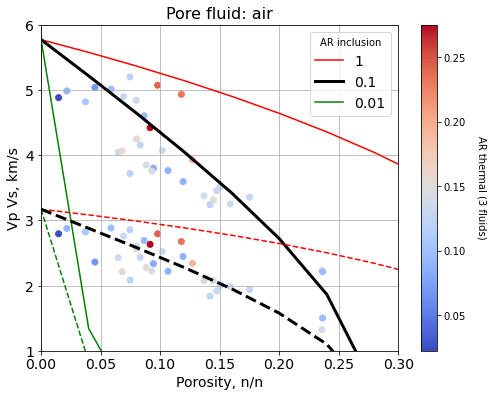

In [ ]:
### Air plot

plt.figure(figsize=(8,6))

### Vp-porosity
porosity_list = np.linspace(0, 0.4, 11)

    ### Vp
plt.plot(porosity_list, Vp_value_1, 'r-', label='1')
plt.plot(porosity_list, Vp_value_01, 'k-', label='0.1', linewidth=3)
plt.plot(porosity_list, Vp_value_001, 'g-', label='0.01')

colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
plt.scatter(data['Porosity,%']/100, data['Vp air'], c=colors, cmap='coolwarm', marker='o')

# plt.scatter(data['Porosity,%']/100, data['Vp air'], color='red')

    ### Vs
plt.plot(porosity_list, Vs_value_1,'r--')
plt.plot(porosity_list, Vs_value_01, 'k--', linewidth=3)
plt.plot(porosity_list, Vs_value_001, 'g--')
plt.scatter(data['Porosity,%']/100, data['Vs air'], c=colors, cmap='coolwarm', marker='o')
# plt.scatter(data['Porosity,%']/100, data['Vs air'], color='red', marker='o')


cbar = plt.colorbar()
cbar.set_label('AR thermal (3 fluids)', rotation=270, labelpad=20)

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Vp Vs, km/s', fontsize=14)     # Set y label and increase font size
plt.title('Pore fluid: air', fontsize=16)  # Set title and increase font size

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xticks(fontsize=14)  # Increase x ticks font size
plt.yticks(fontsize=14)  # Increase y ticks font size


plt.grid()
plt.legend(title='AR inclusion', fontsize=14)

In [ ]:
# ### Water
c11_1 = [101.83339900000001,92.83869652501586,84.05294964762811,75.48154884984223,67.13134251202757,59.011365831084504,\
 51.13526959996483,43.518233503338806,36.191438841924324,29.207305068872714,22.63926001801288]

c12_1 =[44.584649,39.95960373277442,35.5598877493716,31.390460743147578,27.456943518146616,23.7658139128385,\
 20.325225282791827,17.14320302209669,14.232978921590751,11.61274200408233,9.302728933155866]

c44_1 = [28.624375,26.439546396120715,24.24653094912825,22.045544053347328,19.83719949694048,17.622775959123004,\
 15.4050221585865,13.187515240621057,10.979229960166784,8.797281532395193,6.668265542428505]

c11_01 = [101.83339900000001,85.07621948728583,70.51778463792769,57.9324488668091,47.131135968304775,\
 37.94787660368922,30.232219022174736,23.856039475470116,18.685609577575793,14.569659477865736,11.398005291012339]

c12_01 = [44.584649,38.02435416316608,32.29567634073538,27.374851758876286,23.219876873819814,\
 19.769427984847066,16.94647399087324,14.665536657654823,12.83557744073435,11.368308344860965,10.183980683182897]

c44_01 = [28.624375,23.525932662059862,19.11105414859614,15.278798553966412,11.955629547242483,\
 9.089224309421072,6.642872515650753,4.595251408907651,2.9250160684207196,1.6006755665023877,0.6070123039147214]


c11_001 = [101.83339900000001,59.14264780330049,39.73127505478017,29.195281303587514,24.206332860383327,\
 20.533302612479872,17.681444558862644,15.401276293633913,13.537224005795414,11.985019891625749,10.67255246530666]

c12_001 = [44.584649,38.16862263944145,33.479740112552065,29.044141231503293,24.20033556756166,20.530680211146432,\
 17.67854611149693,15.39975435610107,13.536863241853743,11.983334620190504,10.671925421731085]

c44_001 = [28.624375,10.487012581929514,3.1257674711140524,0.07557003604213071,0.0029986464112035536,0.0013112006667593441,\
 0.0014492236830656847,0.0007609687663081907,0.00018038197107747784,0.000842635717644406,0.00031352178774861046]

In [ ]:
### Пересчет компонент тензора (С11, С44) в скорость
def modulus2velosity(RoMatrix, RoFluid, porosity, C11, C44): ### <-- K, mu to Vp, Vs
    density = RoMatrix * (1-porosity) + RoFluid * porosity
    Vp = np.sqrt(C11/ density)
    Vs = np.sqrt(C44/density)
    return Vp, Vs

In [ ]:
Vp_value_1, Vs_value_1 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_1, c44_1):
    Vp, Vs = modulus2velosity(p_calcite, p_water, porosity, C11, C44)
    Vp_value_1.append(Vp)
    Vs_value_1.append(Vs)

In [ ]:
Vp_value_01, Vs_value_01 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_01, c44_01):
    Vp, Vs = modulus2velosity(p_calcite, p_water, porosity, C11, C44)
    Vp_value_01.append(Vp)
    Vs_value_01.append(Vs)

In [ ]:
Vp_value_001, Vs_value_001 = [], []

for porosity, C11, C44 in zip(porosity_list, c11_001, c44_001):
    Vp, Vs = modulus2velosity(p_calcite, p_water, porosity, C11, C44)
    Vp_value_001.append(Vp)
    Vs_value_001.append(Vs)

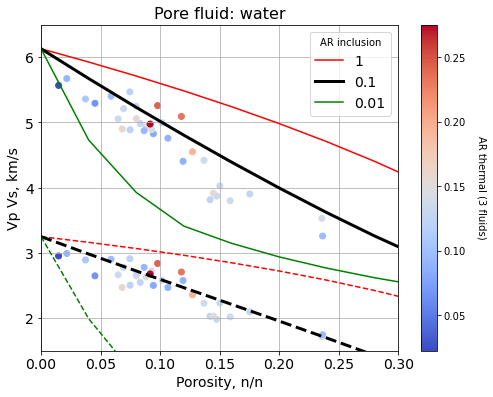

In [ ]:
### Water plot

plt.figure(figsize=(8,6))

### Vp-porosity
porosity_list = np.linspace(0, 0.4, 11)

    ### Vp
plt.plot(porosity_list, Vp_value_1, 'r-', label='1')
plt.plot(porosity_list, Vp_value_01, 'k-', label='0.1', linewidth=3)
plt.plot(porosity_list, Vp_value_001, 'g-', label='0.01')

colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
plt.scatter(data['Porosity,%']/100, data['Vp water'], c=colors, cmap='coolwarm', marker='o')

# plt.scatter(data['Porosity,%']/100, data['Vp air'], color='red')

    ### Vs
plt.plot(porosity_list, Vs_value_1,'r--')
plt.plot(porosity_list, Vs_value_01, 'k--', linewidth=3)
plt.plot(porosity_list, Vs_value_001, 'g--')
plt.scatter(data['Porosity,%']/100, data['Vs water'], c=colors, cmap='coolwarm', marker='o')
# plt.scatter(data['Porosity,%']/100, data['Vs air'], color='red', marker='o')


cbar = plt.colorbar()
cbar.set_label('AR thermal (3 fluids)', rotation=270, labelpad=20)

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Vp Vs, km/s', fontsize=14)     # Set y label and increase font size
plt.title('Pore fluid: water', fontsize=16)  # Set title and increase font size

plt.xlim(0, 0.3)
plt.ylim(1.5, 6.5)

plt.xticks(fontsize=14)  # Increase x ticks font size
plt.yticks(fontsize=14)  # Increase y ticks font size


plt.grid()
plt.legend(title='AR inclusion', fontsize=14)

### Сравнение с берриманом (АО 0.1)

In [ ]:
Vp_berr_water = [6.129596701215929, 5.514353494233723,4.987992781833181,4.5151111234443295,4.077595992384277,\
           3.665771098268981,3.2750726946820046,2.904804334686873,2.557677217538991,2.2393120406972673,1.9568573140584635]

Vs_berr_water = [3.249751622640735,3.018823266067871,2.782835053189592,2.5424369150276784,\
                 2.2976401283359364,2.048336203231547,1.794676715125974,1.5373648937980375,1.2777254843077992,\
 1.017035034435466,0.753544718613626]


Vp_berr_air = [5.769773210692863,5.055530258271884,4.426196900748177,3.8273383802169216,3.2209428519565035,\
 2.5633589241735595,1.7648421931172364,0.043186845010223886,0.006684628057306662,0.004677588182052284,0.0037665984227694166]

Vs_berr_air = [3.1698533845755072,2.911681041351673,2.6356492581968545,2.33747555968083,\
 2.0073791050085044,1.62474722535072,1.134995760960801,0.02811728533943196,0.004311545775576835,\
               0.0029957580757544694,0.0024000075273252148]


In [ ]:
GSA_air_01_vp = [5.77,5.207246572572331,4.63190616891703,4.0350345952288915,3.4016760285730387,2.7005416581919905,\
 1.8482433333054946,0.4256003878813955,0.11074959202653553,0.054968730764543144,0.060635077874194344]

GSA_air_01_vs = [3.17,2.873746931526685,2.576225049672033,2.2690611119904376,1.939683773387078,\
 1.5652957777800265,1.090985896540042,0.25573619965615924,0.0666108859459415,0.03305922218987137,0.036468618625701506]

GSA_water_01_vp = [6.130000000000001,5.673343492145975,5.231698222685381,4.804616082232241,4.392482076420511,\
 3.9964144601012332,3.6182972174909898,3.2616896085481146,2.93065104753337,2.6284940866647055,2.36258019064007]

GSA_water_01_vs = [3.25,2.9833788872044193,2.723552029563229,2.467415846649895,2.2122910847073713,
 1.9558709330266912,1.6960833254882515,1.431522228441633,1.1595102791013774,0.871232286659041,0.5452188698320348]

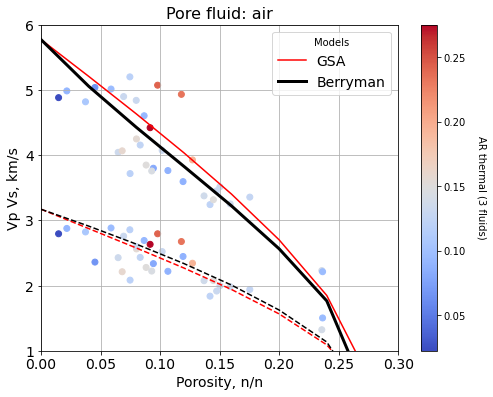

In [ ]:
### Air plot

plt.figure(figsize=(8,6))

### Vp-porosity
porosity_list = np.linspace(0, 0.4, 11)

    ### Vp
plt.plot(porosity_list, GSA_air_01_vp, 'r-', label='GSA')
plt.plot(porosity_list, Vp_berr_air , 'k-', label='Berryman', linewidth=3)


colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
plt.scatter(data['Porosity,%']/100, data['Vp air'], c=colors, cmap='coolwarm', marker='o')

# plt.scatter(data['Porosity,%']/100, data['Vp air'], color='red')

    ### Vs
plt.plot(porosity_list, GSA_air_01_vs, 'r--')
plt.plot(porosity_list, Vs_berr_air , 'k--')

plt.scatter(data['Porosity,%']/100, data['Vs air'], c=colors, cmap='coolwarm', marker='o')
# plt.scatter(data['Porosity,%']/100, data['Vs air'], color='red', marker='o')


cbar = plt.colorbar()
cbar.set_label('AR thermal (3 fluids)', rotation=270, labelpad=20)

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Vp Vs, km/s', fontsize=14)     # Set y label and increase font size
plt.title('Pore fluid: air', fontsize=16)  # Set title and increase font size

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xticks(fontsize=14)  # Increase x ticks font size
plt.yticks(fontsize=14)  # Increase y ticks font size


plt.grid()
plt.legend(title='Models', fontsize=14)

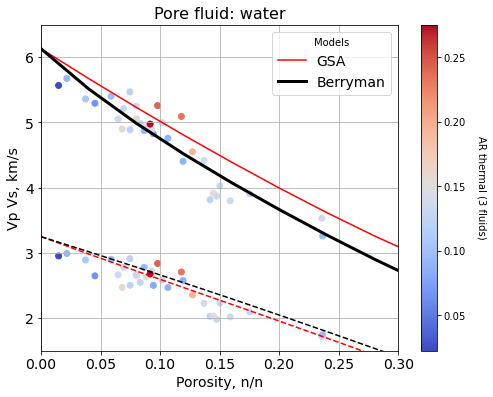

In [ ]:
### Air plot

plt.figure(figsize=(8,6))

### Vp-porosity
porosity_list = np.linspace(0, 0.4, 11)

    ### Vp
plt.plot(porosity_list, GSA_water_01_vp, 'r-', label='GSA')
plt.plot(porosity_list, Vp_berr_water , 'k-', label='Berryman', linewidth=3)


colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
plt.scatter(data['Porosity,%']/100, data['Vp water'], c=colors, cmap='coolwarm', marker='o')

# plt.scatter(data['Porosity,%']/100, data['Vp air'], color='red')

    ### Vs
plt.plot(porosity_list, GSA_water_01_vs, 'r--')
plt.plot(porosity_list, Vs_berr_water , 'k--')

plt.scatter(data['Porosity,%']/100, data['Vs water'], c=colors, cmap='coolwarm', marker='o')
# plt.scatter(data['Porosity,%']/100, data['Vs air'], color='red', marker='o')


cbar = plt.colorbar()
cbar.set_label('AR thermal (3 fluids)', rotation=270, labelpad=20)

plt.xlim(0, 0.3)
plt.ylim(1, 6)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Vp Vs, km/s', fontsize=14)     # Set y label and increase font size
plt.title('Pore fluid: water', fontsize=16)  # Set title and increase font size

plt.xlim(0, 0.3)
plt.ylim(1.5, 6.5)

plt.xticks(fontsize=14)  # Increase x ticks font size
plt.yticks(fontsize=14)  # Increase y ticks font size


plt.grid()
plt.legend(title='Models', fontsize=14)

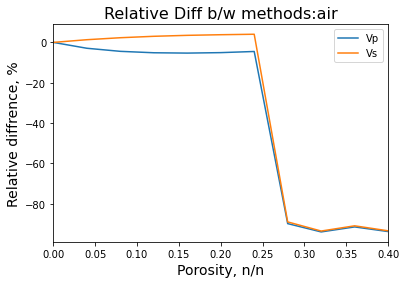

In [ ]:
# Perform element-wise subtraction and division
result_vp_air = [(berr - value)/value*100 for berr, value in zip(Vp_berr_air, GSA_air_01_vp)]
result_vs_air = [(berr - value)/value*100 for berr, value in zip(Vs_berr_air, GSA_air_01_vs)]

# Plot the result
plt.plot(porosity_list, result_vp_air, label='Vp' )
plt.plot(porosity_list, result_vs_air, label='Vs' )
plt.xlim(0, 0.4)
# plt.ylim(-20, 10)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Relative diffrence, %', fontsize=14)     # Set y label and increase font size
plt.title('Relative Diff b/w methods:air', fontsize=16)  # Set title and increase font size
plt.legend()

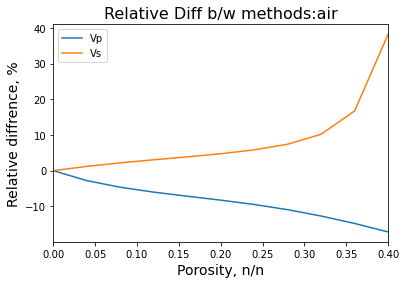

In [ ]:
# Perform element-wise subtraction and division
result_vp_water = [(berr - value)/value*100 for berr, value in zip(Vp_berr_water, GSA_water_01_vp)]
result_vs_water = [(berr - value)/value*100 for berr, value in zip(Vs_berr_water, GSA_water_01_vs)]

# Plot the result
plt.plot(porosity_list, result_vp_water, label='Vp' )
plt.plot(porosity_list, result_vs_water, label='Vs' )
plt.xlim(0, 0.4)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Relative diffrence, %', fontsize=14)     # Set y label and increase font size
plt.title('Relative Diff b/w methods:air', fontsize=16)  # Set title and increase font size
plt.legend()

In [ ]:
# data_air = {
#     'C11': c11_air,
#     'C12': c12_air,
#     'C44': c44_air
# }

# inversion_air = pd.DataFrame(data_air)
# inversion_air['Density (water)'] = data['Density (water)'][0]

# density = 2.572247

# Vp_exp, Vs_exp = data['Vp air'][0], data['Vs air'][0]

# inversion_air['Vp air'] = inversion_air[['C11']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
# inversion_air['Vs air'] = inversion_air[['C44']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
# inversion_air['AR inclusion'] = 1/AR_loop
# inversion_air['Diff Vp'] = inversion_air[['Vp air']].apply(lambda x: np.round(abs(x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
# inversion_air['Diff Vs'] = inversion_air[['Vs air']].apply(lambda x: np.round(abs(x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

# df_sorted_air = inversion_air.sort_values(by='Diff Vp')
# df_sorted_air

### Сравнение с берриманом (АО 0.01)

In [ ]:
Vp_berr_air = [5.769773210692863,1.298102479066479,0.009868804525741586,0.006620256139235399,\
 0.005271641670202492,0.004480876059495537,0.003941819511182704,\
 0.0035419271058545077,0.003227476295544517,0.002971095398937395,0.0027552313612254323]

Vs_berr_air = [3.1698533845755072,0.8611974315892746,0.006400096159852128,0.0042303812379217804,\
 0.003344103564933436,0.0028308575812984182,0.0024846755658419844,0.002229423478740063,0.0020303368597162042,0.0018688290017138329,0.0017337623700214146]

In [ ]:
GSA_air_01_vp = [5.77,1.3384854616706165,0.04906896763386427,0.016886122192305987,0.013836197914593666,0.01138088485989266,0.01287457968421461,\
 0.007786221735144726,0.012706463079118355,0.00867121617570329,0.006211541321342656]

GSA_air_01_vs = Vs_value_001 = [3.17,0.8292566717363965,
 0.030747107944207732,0.010481358322837935,0.00858035513517425,0.007044138245772379,\
 0.00801209070418376,0.004786355126864123,0.007926357615608642,0.005378210232584888,0.003817582840499625]

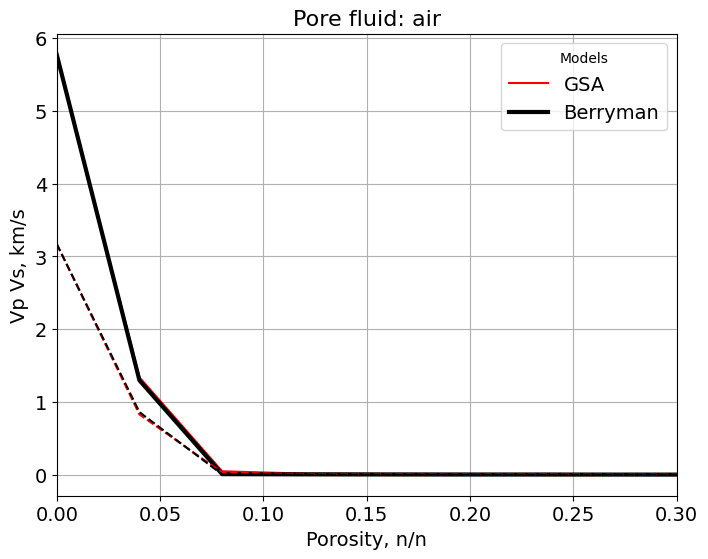

In [ ]:
### Air plot

plt.figure(figsize=(8,6))

### Vp-porosity
porosity_list = np.linspace(0, 0.4, 11)

    ### Vp
plt.plot(porosity_list, GSA_air_01_vp, 'r-', label='GSA')
plt.plot(porosity_list, Vp_berr_air , 'k-', label='Berryman', linewidth=3)


    ### Vs
plt.plot(porosity_list, GSA_air_01_vs, 'r--')
plt.plot(porosity_list, Vs_berr_air , 'k--')



plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Vp Vs, km/s', fontsize=14)     # Set y label and increase font size
plt.title('Pore fluid: air', fontsize=16)  # Set title and increase font size

plt.xlim(0, 0.3)
# plt.ylim(4, 6)

plt.xticks(fontsize=14)  # Increase x ticks font size
plt.yticks(fontsize=14)  # Increase y ticks font size


plt.grid()
plt.legend(title='Models', fontsize=14)

In [ ]:
# porosity_list

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ])

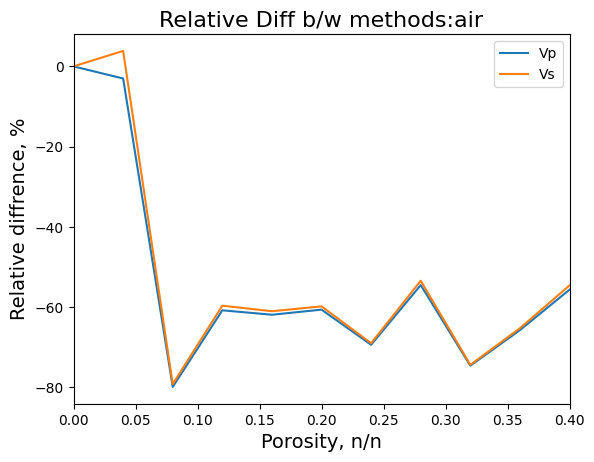

In [ ]:
# Perform element-wise subtraction and division
result_vp_air = [(berr - value)/value*100 for berr, value in zip(Vp_berr_air, GSA_air_01_vp)]
result_vs_air = [(berr - value)/value*100 for berr, value in zip(Vs_berr_air, GSA_air_01_vs)]

# Plot the result
plt.plot(porosity_list, result_vp_air, label='Vp' )
plt.plot(porosity_list, result_vs_air, label='Vs' )
plt.xlim(0, 0.4)
# plt.ylim(-20, 10)

plt.xlabel('Porosity, n/n', fontsize=14)  # Set x label and increase font size
plt.ylabel('Relative diffrence, %', fontsize=14)     # Set y label and increase font size
plt.title('Relative Diff b/w methods:air', fontsize=16)  # Set title and increase font size
plt.legend()

In [ ]:
fluid_list = ['air', 'water', 'oil']

for fluid in fluid_list:
    data_fluid = {
        f'C11_{fluid}': globals()[f'c11_{fluid}'],
        f'C12_{fluid}': globals()[f'c12_{fluid}'],
        f'C44_{fluid}': globals()[f'c44_{fluid}']
    }
    globals()[f'inversion_{fluid}'] = pd.DataFrame(data_fluid)

    if fluid == 'air':
      globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = 2.33
    else:
      globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (water)'][idx]

    # density = data['Density (water)'][idx]
    density = 2.71
    Vp_exp, Vs_exp = data[f'Vp {fluid}'][idx], data[f'Vs {fluid}'][idx]
    porosity = data['Porosity,%'][idx]/100

### Vp, Vs calculation
    globals()[f'inversion_{fluid}'][f'Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'C11_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}'][f'Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'C44_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
### Aspect ratio
    globals()[f'inversion_{fluid}']['AR inclusion'] = np.round(AR_loop, 3)
### Crack density
    ### Если crack density > 1, то в породе преобладают монетообразные трещины,
    ### значит порода может потерять свою целостность. Следовательно, определять
    ### эффективные свойства породы имеет смысл лишь при rack density < 1 .
    globals()[f'inversion_{fluid}']['Crack density'] = np.round(3*porosity/(4*np.pi*AR_loop), 3)

### Relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
    globals()[f'inversion_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'inversion_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff'] = globals()[f'inversion_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

    ### sort values
    globals()[f'inversion_{fluid}'] = globals()[f'inversion_{fluid}'].sort_values(by=f'Diff')


In [ ]:
inversion_air

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
0,34.089639,12.212967,10.938336,2.33,3.546717,2.009051,0.100,0.339,9.43,9.33,13.27
1,52.980793,20.555075,16.212859,2.33,4.421550,2.445936,0.215,0.157,36.43,33.10,49.22
2,61.380614,23.579738,18.900438,2.33,4.759167,2.640896,0.464,0.073,46.84,43.71,64.07
3,62.148877,22.683897,19.732490,2.33,4.788858,2.698400,1.000,0.034,47.76,46.84,66.90


### Выбор лучшего решения по трем флюидам

In [ ]:
error = 10

In [ ]:
selected_row = inversion_air[(inversion_air['Diff Vp air'] <= error ) &\
                             (inversion_air['Diff Vs air'] <= error)]
selected_row


,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
0,21.848101,7.603625,7.122238,2.36,3.064755,1.749835,0.032,1.071,5.44,4.78,7.24


In [ ]:
selected_row = inversion_water[(inversion_water['Diff Vp water'] <= error) &\
                               (inversion_water['Diff Vs water']  <= error)]
selected_row

,C11_water,C12_water,C44_water,Density (water),Vp water,Vs water,AR inclusion,Crack density,Diff Vp water,Diff Vs water,Diff


In [ ]:
selected_row = inversion_oil[(inversion_oil['Diff Vp oil'] <= error) &\
                             (inversion_oil['Diff Vs oil'] <= error)]
selected_row

,C11_oil,C12_oil,C44_oil,Density (oil),Vp oil,Vs oil,AR inclusion,Crack density,Diff Vp oil,Diff Vs oil,Diff


In [ ]:
    ### AR value for thermal & electrical properties
AR_thermal = np.round(data['AR thermal'][idx], 2)
AR_electrical = np.round(data['AO electrical'][idx], 2)
print(AR_thermal, AR_electrical )

0.12 0.1


### Direct problem

In [ ]:
AR_thermal = data['AR thermal']

In [ ]:
AR_thermal

0     0.066681
1     0.134276
2     0.131826
3     0.122462
4     0.081658
5     0.144544
6     0.149968
7     0.120226
8          NaN
9     0.158489
10    0.124738
11    0.155597
12    0.127057
13    0.131826
14    0.242103
15    0.139316
16    0.275423
17    0.087902
18    0.233346
19    0.136773
20    0.131826
21    0.149968
22    0.134276
23    0.092897
24    0.087902
25    0.107647
26    0.091201
27    0.022491
28    0.131826
29    0.120226
30    0.096383
31    0.131826
32    0.096383
33    0.194089
Name: AR thermal, dtype: float64

In [ ]:

porosity = data['Porosity,%']/100

density  = data['Density (water)']


C_mtrx = make_C_matrix(K_calcite, mu_calcite)
C_c = C_mtrx
g_matrix = tensor_g_fast(C_c, [1, 1, 1])

ar_inclusion = AR_thermal **-1
g_inclusion= tensor_g_fast(C_c, [ar_inclusion, ar_inclusion, 1])

eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  make_C_fluid (K_air, Mu_air),
                                  C_c, porosity)

c11_air,c44_air  = eff_air[0,0], eff_air[3,3]
vp_air = np.sqrt(c11_air / density)
vs_air = np.sqrt(c44_air / density)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 3) + inhomogeneous part.